
# Opening a Restaurant in Colombo 

## Introduction / Business Problem

Colombo is the commercial capital and largest city of Sri Lanka by population. According to the Brookings Institution, Colombo metropolitan area has a population of 5.6 million, and 752,993 in the city proper. It is the financial center of the island and a tourist destination. Colombo is arguably Sri Lanka's most popular tourist destination. The coastal city is a beautiful place to spend a couple of days just relaxing, indulging in the local food, and leisure activities. In Colombo, most common restaurants are aimed at tourists, with a mix of Sri Lankan, seafood and Western dishes and South Indian-style places.

Our stakeholder is willing to open a restaurant in Colombo. Choosing a restaurant type and a good spot, relies on common sense and domain knowledge. Data science provides valuable insights regarding market trends and consumer lifestyles so that stakeholder can better address and meet public demand. In this project, we will implement the basic analysis and try to find the most optimal sub-urbs to open the restaurant according to those criteria. It's obvious, that there are many additional factors, such as distance from parking places or distance from the main streets, but this analysis mainly focuses on the type of restaurants

## Data

The problem will be addressed in following steps:

Step 1. Using a table on 'https://en.wikipedia.org/wiki/Colombo#:~:text=Colombo%20, collect information about Colombo suburbs.

Step 2. Use the Geopy and Folium library to get the coordinates of every locations and map geospatial data on a Colombo map.

Step 3. Using Foursquare API, collect the top 100 restaurants and their categories for each location within a radius 1000 meters.

Step 4. Group collected restaurants by location and by taking the mean of the frequency of occurrence of each type, preparing them for clustering.

Step 5. Cluster restaurants by k-means algorithm and analyze the top 5 most common restaurants in each cluster.

Step 6. Visualize clusters on the map, thus showing the best locations for opening the chosen restaurant.

## Methodology

Before we get the data and start exploring it, let's import the packages that we will need.

In [126]:
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


# !pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


# ! pip install folium==0.5.0
import folium # plotting library

import geocoder

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


###  Steps for data cleaning

The data was converted in to a pandas data frame.

In [2]:
data = requests.get("https://en.wikipedia.org/wiki/Colombo#:~:text=Colombo%20(/%20k%C9%99%CB%88l%CA%8Cmbo%CA%8A%20/;%20Sinhala:%20%E0%B6%9A%E0%B7%9C%E0%B7%85%E0%B6%B9,%20romanized:%20Kolamba,,and%20largest%20city%20of%20Sri%20Lanka%20by%20population.").text

In [120]:
import urllib
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/Colombo#:~:text=Colombo%20(/%20k%C9%99%CB%88l%CA%8Cmbo%CA%8A%20/;%20Sinhala:%20%E0%B6%9A%E0%B7%9C%E0%B7%85%E0%B6%B9,%20romanized:%20Kolamba,,and%20largest%20city%20of%20Sri%20Lanka%20by%20population.'

result = requests.get(url).text

# pass the data into beautifulsoup
soup = BeautifulSoup(result, 'lxml')

In [121]:
table = soup.find_all('table')[2]
print(table)

<table class="wikitable">
<tbody><tr>
<td style="width:100px;">Postal number</td>
<td>City suburb
</td></tr>
<tr>
<td>Colombo 1</td>
<td><a href="/wiki/Fort_(Colombo)" title="Fort (Colombo)">Fort</a>
</td></tr>
<tr>
<td>Colombo 2</td>
<td><a href="/wiki/Slave_Island" title="Slave Island">Slave Island</a>, <a href="/wiki/Union_Place" title="Union Place">Union Place</a>
</td></tr>
<tr>
<td>Colombo 3</td>
<td><a href="/wiki/Kollupitiya" title="Kollupitiya">Kollupitiya</a>
</td></tr>
<tr>
<td>Colombo 4</td>
<td><a href="/wiki/Bambalapitiya" title="Bambalapitiya">Bambalapitiya</a>
</td></tr>
<tr>
<td>Colombo 5</td>
<td><a href="/wiki/Havelock_Town" title="Havelock Town">Havelock Town</a>, <a href="/wiki/Kirulapana" title="Kirulapana">Kirulapone</a>, <a href="/wiki/Kirilapone_North" title="Kirilapone North">Kirulapone North</a>
</td></tr>
<tr>
<td>Colombo 6</td>
<td><a href="/wiki/Wellawatte" title="Wellawatte">Wellawatte</a>, <a href="/wiki/Pamankada" title="Pamankada">Pamankada</a>,
</td><

In [122]:
column_names = ['Postal number', 'City suburb']

df = pd.DataFrame(columns=column_names)

In [123]:
# append the data from soup object to the data frame
for row in table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells)>0:
        df = df.append({'Postal number': cells[0].text.rstrip('\n'), 'City suburb': cells[1].text.rstrip('\n')}, ignore_index=True)
                       
df.head(5)

,Postal number,City suburb
0,Postal number,City suburb
1,Colombo 1,Fort
2,Colombo 2,"Slave Island, Union Place"
3,Colombo 3,Kollupitiya
4,Colombo 4,Bambalapitiya


In [124]:
df.drop(df.index[0], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Postal number,City suburb
0,Colombo 1,Fort
1,Colombo 2,"Slave Island, Union Place"
2,Colombo 3,Kollupitiya
3,Colombo 4,Bambalapitiya
4,Colombo 5,"Havelock Town, Kirulapone, Kirulapone North"


### Adding Longitude and Latitudes to the dataframe 

In [125]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Colombo, Sri Lanka'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [127]:
coords = [ get_latlng(neighborhood) for neighborhood in df["City suburb"].tolist() ]

In [128]:
address = 'Colombo, Sri Lanka'

geolocator = Nominatim(user_agent="colombo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Colombo City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Colombo City are 6.9349969, 79.8538463.


In [129]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [130]:
# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [131]:
df = df.rename(columns = {'City suburb':'Neighborhood'})
df.head()

,Postal number,Neighborhood,Latitude,Longitude
0,Colombo 1,Fort,6.941480,79.846640
1,Colombo 2,"Slave Island, Union Place",6.922123,79.854221
2,Colombo 3,Kollupitiya,6.912930,79.851280
3,Colombo 4,Bambalapitiya,6.904710,79.855070
4,Colombo 5,"Havelock Town, Kirulapone, Kirulapone North",6.881350,79.875920


In [138]:
# create map of olombo using latitude and longitude values
map_col = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_col)  
    
map_col

### Let's explore a neighborhood in our dataframe

In [139]:
df.loc[0, 'Neighborhood']

'Fort'

In [142]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of suburb {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude)) 

Latitude and longitude values of suburb Fort are 6.94148000000007, 79.84664000000004.


### Now, let's get the top 100 venues that are within a radius of 1000 meters.

In [143]:
# @hidden_cell


In [144]:
LIMIT=100
radius=1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=restaurant'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

category_results = requests.get(url).json()
category_results

{'meta': {'code': 200, 'requestId': '602221e05a01592844f42da5'},
 'response': {'headerLocation': 'Colombo',
  'headerFullLocation': 'Colombo',
  'headerLocationGranularity': 'city',
  'query': 'restaurant',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 6.981300009000084,
    'lng': 79.88437013108789},
   'sw': {'lat': 6.963299991000066, 'lng': 79.8662698689122}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4de24f537d8b2547eb002c07',
       'name': 'Good Food',
       'location': {'lat': 6.9715675775323245,
        'lng': 79.87387934943084,
        'labeledLatLngs': [{'label': 'display',
          'lat': 6.9715675775323245,
          'lng': 79.87387934943084}],
        'distance': 178,
        'postalCode': '00150',
        'cc': 'LK',
        'city': 'කොළඹ

In [145]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Clean the json and structure it into a pandas dataframe

In [147]:
venues = category_results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Good Food,Diner,6.971568,79.873879
1,Twoso,Halal Restaurant,6.971694,79.875471
2,Perera & Sons,Bakery,6.972027,79.873464
3,dine more,Diner,6.972406,79.866929


### Explore Neighborhoods in Colombo

In [148]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=restaurant'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [149]:
colombo_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Fort
Slave Island, Union Place
Kollupitiya
Bambalapitiya
Havelock Town, Kirulapone, Kirulapone North
Wellawatte, Pamankada,
Cinnamon Gardens
Borella
Dematagoda
Maradana, Panchikawatte
Pettah
Hulftsdorp
Kotahena, Bloemendhal
Grandpass
Modara/Mutwal, Mattakkuliya, Madampitiya


In [152]:
print(colombo_venues.shape)
colombo_venues.head()

(561, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fort,6.94148,79.84664,Ministry Of Crab,6.933673,79.843499,Seafood Restaurant
1,Fort,6.94148,79.84664,& Co.,6.934104,79.842830,English Restaurant
2,Fort,6.94148,79.84664,Sri Suryas Hotel,6.942696,79.854711,Indian Restaurant
3,Fort,6.94148,79.84664,Pizza Hut,6.934417,79.844303,Pizza Place
4,Fort,6.94148,79.84664,Ikoi Tei,6.933578,79.843599,Japanese Restaurant


In [153]:
colombo_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bambalapitiya,100,100,100,100,100,100
Borella,38,38,38,38,38,38
Cinnamon Gardens,63,63,63,63,63,63
Dematagoda,6,6,6,6,6,6
Fort,26,26,26,26,26,26
Grandpass,13,13,13,13,13,13
"Havelock Town, Kirulapone, Kirulapone North",30,30,30,30,30,30
Hulftsdorp,25,25,25,25,25,25
Kollupitiya,100,100,100,100,100,100


### Analyze Each Neighborhood

In [154]:
# one hot encoding
colombo_onehot = pd.get_dummies(colombo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
colombo_onehot['Neighborhood'] = colombo_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [colombo_onehot.columns[-1]] + list(colombo_onehot.columns[:-1])
colombo_onehot = colombo_onehot[fixed_columns]

colombo_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Cafeteria,...,Seafood Restaurant,Snack Place,South Indian Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
0,Fort,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Fort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Fort,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
print('There are {} uniques categories.'.format(len(colombo_venues['Venue Category'].unique())))

There are 55 uniques categories.


In [157]:
# print out the list of categories
colombo_venues['Venue Category'].unique()[::]

array(['Seafood Restaurant', 'English Restaurant', 'Indian Restaurant',
       'Pizza Place', 'Japanese Restaurant', 'Asian Restaurant',
       'Restaurant', 'Vegetarian / Vegan Restaurant',
       'American Restaurant', 'Mexican Restaurant',
       'Cajun / Creole Restaurant', 'Food Truck', 'Chinese Restaurant',
       'Sri Lankan Restaurant', 'Cafeteria', 'Food',
       'Fast Food Restaurant', 'Bakery', 'South Indian Restaurant',
       'German Restaurant', 'Café', 'Noodle House', 'Bistro', 'Diner',
       'French Restaurant', 'Gastropub', 'Sandwich Place',
       'Thai Restaurant', 'Steakhouse', 'Tapas Restaurant',
       'Italian Restaurant', 'Malay Restaurant', 'Snack Place',
       'Food Court', 'Cuban Restaurant', 'Breakfast Spot', 'Buffet',
       'Sushi Restaurant', 'Fondue Restaurant', 'North Indian Restaurant',
       'Middle Eastern Restaurant', 'Dim Sum Restaurant', 'Deli / Bodega',
       'Mediterranean Restaurant', 'Poke Place', 'Halal Restaurant',
       'BBQ Joint', 'B

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [158]:
colombo_grouped = colombo_onehot.groupby('Neighborhood').mean().reset_index()
colombo_grouped

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Cafeteria,...,Seafood Restaurant,Snack Place,South Indian Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
0,Bambalapitiya,0.000000,0.040000,0.01,0.060000,0.000000,0.000000,0.010000,0.000000,0.000000,...,0.030000,0.010000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.040000,0.010000
1,Borella,0.000000,0.026316,0.00,0.157895,0.000000,0.026316,0.026316,0.000000,0.052632,...,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632
2,Cinnamon Gardens,0.031746,0.000000,0.00,0.079365,0.000000,0.031746,0.000000,0.000000,0.000000,...,0.000000,0.031746,0.015873,0.031746,0.000000,0.000000,0.015873,0.000000,0.015873,0.000000
3,Dematagoda,0.000000,0.166667,0.00,0.166667,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Fort,0.038462,0.153846,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,...,0.076923,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923
5,Grandpass,0.000000,0.153846,0.00,0.307692,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923
6,"Havelock Town, Kirulapone, Kirulapone North",0.000000,0.066667,0.00,0.066667,0.000000,0.000000,0.000000,0.033333,0.033333,...,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333
7,Hulftsdorp,0.000000,0.240000,0.00,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000
8,Kollupitiya,0.000000,0.080000,0.00,0.050000,0.010000,0.010000,0.010000,0.000000,0.000000,...,0.050000,0.020000,0.010000,0.050000,0.010000,0.000000,0.000000,0.010000,0.010000,0.010000
9,"Kotahena, Bloemendhal",0.000000,0.125000,0.00,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [164]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ["Neighborhood"]
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = colombo_grouped['Neighborhood']

for ind in np.arange(colombo_grouped.shape[0]):
    row_categories = colombo_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bambalapitiya,Café,Fast Food Restaurant,Restaurant,Chinese Restaurant,Indian Restaurant,Sri Lankan Restaurant,Bakery,Asian Restaurant,Thai Restaurant,Seafood Restaurant
1,Borella,Restaurant,Bakery,Café,Vegetarian / Vegan Restaurant,Pizza Place,Cafeteria,Halal Restaurant,Donut Shop,Indian Chinese Restaurant,Italian Restaurant
2,Cinnamon Gardens,Café,Restaurant,Fast Food Restaurant,Bakery,Indian Restaurant,Japanese Restaurant,Chinese Restaurant,Breakfast Spot,American Restaurant,Sri Lankan Restaurant
3,Dematagoda,Asian Restaurant,Bakery,Food Court,Fast Food Restaurant,Cafeteria,Chinese Restaurant,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Food Truck,Food
4,Fort,Asian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Restaurant,Pizza Place,Mexican Restaurant,Cafeteria,Cajun / Creole Restaurant,Chinese Restaurant


#### Let's print each neighborhood along with the top 10 most common venues

In [163]:
num_top_venues = 10

for hood in colombo_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = colombo_grouped[colombo_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bambalapitiya----
                   venue  freq
0                   Café  0.15
1   Fast Food Restaurant  0.11
2             Restaurant  0.11
3     Chinese Restaurant  0.10
4      Indian Restaurant  0.08
5  Sri Lankan Restaurant  0.07
6                 Bakery  0.06
7        Thai Restaurant  0.04
8       Asian Restaurant  0.04
9    Japanese Restaurant  0.03


----Borella----
                           venue  freq
0                     Restaurant  0.18
1                         Bakery  0.16
2                           Café  0.16
3  Vegetarian / Vegan Restaurant  0.05
4                      Cafeteria  0.05
5                    Pizza Place  0.05
6          Sri Lankan Restaurant  0.03
7       Mediterranean Restaurant  0.03
8      Indian Chinese Restaurant  0.03
9             Mexican Restaurant  0.03


----Cinnamon Gardens----
                   venue  freq
0                   Café  0.22
1             Restaurant  0.14
2   Fast Food Restaurant  0.10
3                 Bakery  0.08
4      I

### Cluster Neighborhoods

To identify the optimal number of clusters, the Elbow method is used.

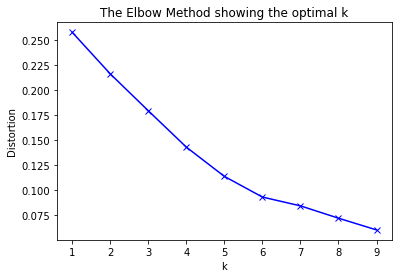

In [165]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

colombo_grouped_clustering = colombo_grouped.drop('Neighborhood', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(colombo_grouped_clustering)
    kmeanModel.fit(colombo_grouped_clustering)
    distortions.append(sum(np.min(cdist(colombo_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / colombo_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the graph, we can see that 6 clusters are enough.

#### Run k-means to cluster the neighborhood into 6 clusters.

In [168]:
# set number of clusters
kclusters = 6

colombo_grouped_clustering = colombo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(colombo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 5, 0, 3, 1, 0, 1, 3, 4, 2, 0, 1, 1])

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [169]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

colombo_merged = df

# merge jefferson_grouped with jefferson_data to add latitude/longitude for each neighborhood
colombo_merged = colombo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
colombo_merged = colombo_merged.dropna()
colombo_merged.reset_index(drop=True, inplace=True)
colombo_merged.head() # check the last columns!

,Postal number,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Colombo 1,Fort,6.941480,79.846640,0,Asian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Restaurant,Pizza Place,Mexican Restaurant,Cafeteria,Cajun / Creole Restaurant,Chinese Restaurant
1,Colombo 2,"Slave Island, Union Place",6.922123,79.854221,1,Restaurant,Café,Bakery,Fast Food Restaurant,Seafood Restaurant,Asian Restaurant,Sri Lankan Restaurant,Japanese Restaurant,Indian Restaurant,Diner
2,Colombo 3,Kollupitiya,6.912930,79.851280,1,Restaurant,Café,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Indian Restaurant,Bakery,Sri Lankan Restaurant,Seafood Restaurant,Japanese Restaurant
3,Colombo 4,Bambalapitiya,6.904710,79.855070,1,Café,Fast Food Restaurant,Restaurant,Chinese Restaurant,Indian Restaurant,Sri Lankan Restaurant,Bakery,Asian Restaurant,Thai Restaurant,Seafood Restaurant
4,Colombo 5,"Havelock Town, Kirulapone, Kirulapone North",6.881350,79.875920,1,Indian Restaurant,Café,Pizza Place,Restaurant,Asian Restaurant,Fast Food Restaurant,Bakery,Vegetarian / Vegan Restaurant,Thai Restaurant,Donut Shop


#### Ploting Clusters in the Map

In [179]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(colombo_merged['Latitude'], colombo_merged['Longitude'], colombo_merged['Neighborhood'], colombo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**MAP LEGEND**

Cluster 1 - red dots

Cluster 2 - purple dots

Cluster 3 - blue dots

Cluster 5 - light blue dots

Cluster 5 - light green dots

Cluster 6 - orange dots

## Results

And now we are ready to conclude our report.

### Examine Clusters

Let's examine each cluster and the discriminating restaurant categories that distinguish a cluster.

#### Cluster 1

In [180]:
colombo_merged.loc[colombo_merged['Cluster Labels'] == 0, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Fort,Asian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Restaurant,Pizza Place,Mexican Restaurant,Cafeteria,Cajun / Creole Restaurant,Chinese Restaurant
10,Pettah,Indian Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Food,Sri Lankan Restaurant,Cafeteria,Restaurant,Pizza Place,Food Truck,Fondue Restaurant
11,Hulftsdorp,Indian Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Food Truck,Bakery,Food,Hot Dog Joint,Restaurant,Fast Food Restaurant,Eastern European Restaurant


In [181]:
cluster_1 = colombo_merged.loc[colombo_merged['Cluster Labels'] == 0, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]
cluster_1.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,3,3,3,3,3,3,3,3,3,3,3
unique,3,2,2,1,3,3,3,3,3,3,3
top,Pettah,Indian Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Food,Bakery,Pizza Place,Restaurant,Pizza Place,Fast Food Restaurant,Fondue Restaurant
freq,1,2,2,3,1,1,1,1,1,1,1


#### Cluster 2

In [182]:
colombo_merged.loc[colombo_merged['Cluster Labels'] == 1, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Slave Island, Union Place",Restaurant,Café,Bakery,Fast Food Restaurant,Seafood Restaurant,Asian Restaurant,Sri Lankan Restaurant,Japanese Restaurant,Indian Restaurant,Diner
2,Kollupitiya,Restaurant,Café,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Indian Restaurant,Bakery,Sri Lankan Restaurant,Seafood Restaurant,Japanese Restaurant
3,Bambalapitiya,Café,Fast Food Restaurant,Restaurant,Chinese Restaurant,Indian Restaurant,Sri Lankan Restaurant,Bakery,Asian Restaurant,Thai Restaurant,Seafood Restaurant
4,"Havelock Town, Kirulapone, Kirulapone North",Indian Restaurant,Café,Pizza Place,Restaurant,Asian Restaurant,Fast Food Restaurant,Bakery,Vegetarian / Vegan Restaurant,Thai Restaurant,Donut Shop
5,"Wellawatte, Pamankada,",Restaurant,Indian Restaurant,Bakery,Asian Restaurant,Fast Food Restaurant,Café,Sri Lankan Restaurant,Vegetarian / Vegan Restaurant,Breakfast Spot,Diner
6,Cinnamon Gardens,Café,Restaurant,Fast Food Restaurant,Bakery,Indian Restaurant,Japanese Restaurant,Chinese Restaurant,Breakfast Spot,American Restaurant,Sri Lankan Restaurant
7,Borella,Restaurant,Bakery,Café,Vegetarian / Vegan Restaurant,Pizza Place,Cafeteria,Halal Restaurant,Donut Shop,Indian Chinese Restaurant,Italian Restaurant


In [183]:
cluster_2 = colombo_merged.loc[colombo_merged['Cluster Labels'] == 1, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]
cluster_2.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,7,7,7,7,7,7,7,7,7,7,7
unique,7,3,5,6,6,5,7,4,6,6,6
top,Borella,Restaurant,Café,Bakery,Asian Restaurant,Fast Food Restaurant,Fast Food Restaurant,Bakery,Vegetarian / Vegan Restaurant,Thai Restaurant,Diner
freq,1,4,3,2,2,2,1,3,2,2,2


#### Cluster 3

In [184]:
colombo_merged.loc[colombo_merged['Cluster Labels'] == 2, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Modara/Mutwal, Mattakkuliya, Madampitiya",Diner,Halal Restaurant,Bakery,Vegetarian / Vegan Restaurant,Deli / Bodega,Food Truck,Food Court,Food,Fondue Restaurant,Fast Food Restaurant


In [185]:
cluster_3 = colombo_merged.loc[colombo_merged['Cluster Labels'] == 2, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]
cluster_3.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1
top,"Modara/Mutwal, Mattakkuliya, Madampitiya",Diner,Halal Restaurant,Bakery,Vegetarian / Vegan Restaurant,Deli / Bodega,Food Truck,Food Court,Food,Fondue Restaurant,Fast Food Restaurant
freq,1,1,1,1,1,1,1,1,1,1,1


#### Cluster 4

In [186]:
colombo_merged.loc[colombo_merged['Cluster Labels'] == 3, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Kotahena, Bloemendhal",Bakery,German Restaurant,Asian Restaurant,Food Court,Indian Restaurant,Fast Food Restaurant,Deli / Bodega,Food Truck,Food,Fondue Restaurant
13,Grandpass,Bakery,Asian Restaurant,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Food Court,Chinese Restaurant,Dim Sum Restaurant,Food Truck,Food


In [187]:
cluster_4 = colombo_merged.loc[colombo_merged['Cluster Labels'] == 3, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]
cluster_4.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,2,2,2,2,2,2,2,2,2,2,2
unique,2,1,2,2,2,2,2,2,2,2,2
top,Grandpass,Bakery,German Restaurant,Asian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Food,Fondue Restaurant
freq,1,2,1,1,1,1,1,1,1,1,1


#### Cluster 5

In [188]:
colombo_merged.loc[colombo_merged['Cluster Labels'] == 4, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Maradana, Panchikawatte",Asian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Bakery,Diner,Deli / Bodega,Food Truck,Food Court,Food,Fondue Restaurant


In [189]:
cluster_5 = colombo_merged.loc[colombo_merged['Cluster Labels'] == 4, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]
cluster_5.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1
top,"Maradana, Panchikawatte",Asian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Bakery,Diner,Deli / Bodega,Food Truck,Food Court,Food,Fondue Restaurant
freq,1,1,1,1,1,1,1,1,1,1,1


#### Cluster 6

In [190]:
colombo_merged.loc[colombo_merged['Cluster Labels'] == 5, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Dematagoda,Asian Restaurant,Bakery,Food Court,Fast Food Restaurant,Cafeteria,Chinese Restaurant,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Food Truck,Food


In [191]:
cluster_6 = colombo_merged.loc[colombo_merged['Cluster Labels'] == 5, colombo_merged.columns[[1] + list(range(5, colombo_merged.shape[1]))]]
cluster_6.describe(include='all')

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1
top,Dematagoda,Asian Restaurant,Bakery,Food Court,Fast Food Restaurant,Cafeteria,Chinese Restaurant,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Food Truck,Food
freq,1,1,1,1,1,1,1,1,1,1,1


## Discussion

Analyzing the most popular restaurants in each cluster, it seems colombo is famous for spicy foods, especially Inian/Asian foods
the stakeholder should prefer the popular types as a safe choice.

However stake holder can take a risk and can add novelty to open a restaurent related to mediteranian, american or european foods since Colombo is lacking oncusines other tha asian.

But bear in mind that descending on the popularity we might face an absence of demand for this type of food, 
and open a restaurant that is not needed in this particular location. Presence of interested customers is a must for 
a successful business.

Recommendations, based on description of each cluster:
Cluster 1 Locations: Indian and or Pizza are popular
Cluster 2 Locations: Asian and Fast Foods are populer
Cluster 3 Locations: Halal or Vegitarian Foods are populer
Cluster 4 Locations: Bakery and European Foods are populer
Cluster 5 Locations: Asian Foods or Vegetarian Foods are populer
Cluster 6 Locations: Asian Foods or Fast Foods are populer

After the type of restaurant is chosen, it is time to select a right place. Using the map created in section 3.8.3.

## Conclusion

In this report we worked out a methodology to determine what the most promising type of restaurant is and where it should be opened.

We collected information about Colombo suburbs from Wikipedia, and using geospatial libraries mapped them. Using Foursquare API, we collected the top 100 restaurants and their types for each location within a radius 1000 meters from its central point. Then we grouped collected restaurants by location and by taking the mean of the frequency of occurrence of each type, preparing them for clustering. Finally we clustered restaurants by the k-means algorithm and analize the top 10 most common restaurants in each cluster, making useful observations. Eventually we visualized clusters on the map, thus showing the best locations for opening the chosen type of restaurant.

This type of analysis can be applied to any city of your choice that has available geospatial information.

This type of analysis can be applied to any type of venue (shopping, clubs, etc.) that is available in Foursquare database.